# Phase Transitions

This notebook implement the effective potential with manually made functions to solve for the nucleation temperature and other parameters.

In [1]:
import numpy as np
from scipy import optimize
from cosmoTransitions import generic_potential as gp
from cosmoTransitions import pathDeformation as pd
from scipy import interpolate
from cosmoTransitions import helper_functions

## Pre-definitions

In [2]:
GF = 1.16637e-05
v = 1/(np.sqrt(2*np.sqrt(2)*GF))
mHSM = 125.13

In [3]:
def muH2(mS, sintheta):
    """\mu_H square"""
    return 0.5*(mHSM**2 * (1-sintheta**2) + mS**2 * sintheta**2)

def muS2(mS, sintheta):
    """\mu_S square"""
    return sintheta**2 * mHSM**2 + (1 - sintheta**2) * mS**2

def A(mS, sintheta):
    """A parameter"""
    nominator = (mHSM**2 - mS**2) * sintheta * np.sqrt(1-sintheta**2)
    denominator = np.sqrt(2) * v
    return nominator/denominator

def lm(mS, sintheta):
    """\lambda parameter"""
    nominator = (1 - sintheta**2)*mHSM**2 + sintheta**2 * mS**2
    return nominator/(4*v**2)

def sintheta(mS, ft):
    """Solve the mixing angle according to find-tuning"""
    return (mS**2*(1/ft-1)/(mHSM**2-mS**2))**0.5

## The effective potential

In [25]:
class model(gp.generic_potential):
    def init(self, mS, sintheta):
        self.Ndim = 2
        self.Tmax = 100
        self.mS = mS
        self.sintheta = sintheta
        self.lm = lm(self.mS, self.sintheta)
        self.A = A(self.mS,self.sintheta)
        self.muH2 = muH2(self.mS,self.sintheta)
        self.muS2 = muS2(self.mS,self.sintheta)
        self.g = 0.65
        self.gY = 0.36
        self.yt = 0.9945
        self.D = (3*self.g**2 + self.gY**2 + 4*self.yt**2)/16.
        self.E = (2*self.g**3+(self.g**2 + self.gY**2)**(3/2))/(48*np.pi)
        self.cs = 1./3
        self.Deff = self.D - self.cs * self.A**2/(4.*self.muS2)
        self.lmeff = self.lm - self.A**2/(2*self.muS2)
        self.T0 = np.sqrt(0.5*self.muH2 - v**2 * self.A**2 /(2*self.muS2))/np.sqrt(self.D - self.cs*self.A**2/(4*self.muS2))
        self.Tc = self.T0*np.sqrt((self.Deff * self.lmeff)/(-self.E**2 + self.Deff*self.lmeff))
        self.strength = 2*self.E/self.lmeff
        self.Tn = False
        self.Tn1d=False
        self.action_trace_data=[]
        self.T_eps=5e-4


    def Vtot(self, X, T, include_radiation=True):
        """The total effective potential in the high-T expansion."""
        T = np.asanyarray(T, dtype=float)
        X = np.asanyarray(X, dtype=float)
        T2 = (T*T)+1e-100
        phi1 = X[...,0]
        phi2 = X[...,1]
        y = self.D * T2 * phi1**2 - 0.5 * self.muH2 * phi1**2
        y += - self.E * T * phi1**3
        y += 0.25 * self.lm * phi1**4
        y += 0.5*self.muS2*phi2**2 - 0.5 * self.A * (phi1**2 + self.cs * T2 - 2 * v**2)*phi2

        return y

    def Vtot1d(self, X, T, include_radiation=True):
        T = np.asanyarray(T, dtype=float)
        X = np.asanyarray(X, dtype=float)
        T2 = (T*T) + 1e-100
        phi1 = X[...,0]
        y = self.Deff * T2 * phi1**2 - (0.5*self.muH2 - 0.5 * v**2 * self.A**2 / (self.muS2))*phi1**2
        y += - self.E * T * phi1 **3
        y += 0.25 * self.lmeff * phi1**4
        return y

    def truevev(self,T):
        assert T < self.Tc
        nominator = 3.* T * self.E + np.sqrt(9.*self.E**2 * T**2 + 8.*self.Deff * (self.T0**2 - T**2)*self.lmeff)
        denominator = 2.*self.lmeff
        return nominator/denominator

    def Spath(self, X, T):
        X = np.asanyarray(X)
        T = np.asanyarray(T)
        phi1 = X[...,0]
        T2 = (T*T) + 1e-100
        return 0.5*self.A*(phi1**2 + self.cs * T2 - 2 * v**2)/self.muS2

    def gradV1d(self,X,T):
        f=helper_functions.gradientFunction(self.Vtot1d, self.x_eps,1,self.deriv_order)
        T = np.asanyarray(T)[...,np.newaxis, np.newaxis]
        return f(X,T,False)

    def tunneling_at_T_1d(self, T):
        assert T < self.Tc
        def V_(x, T=T, V=self.Vtot1d):
            return V(x,T)
        def dV_(x, T=T, dV=self.gradV1d):
            return dV(x,T)
        tobj = pd.fullTunneling([[self.truevev(T)],[0.]],V_,dV_)
        return tobj

    def tunneling_at_T(self,T):
        assert T < self.Tc
        def V_(x, T=T, V=self.Vtot):
            return V(x,T)
        def dV_(x, T=T, dV=self.gradV):
            return dV(x,T)
        tobj = pd.fullTunneling([[self.truevev(T),self.Spath([self.truevev(T)],T)],[0.,self.Spath([0.],T)]],V_,dV_)
        return tobj 

    def S_over_T(self,T):
        Tv=T
        ST=self.tunneling_at_T(T=Tv).action/Tv
        return ST

    def findTn_1d(self):
        print("Finding nucleation temperature for 1d case...")
        if self.mS<=0.1:
            eps = 0.03
        elif self.mS<=1:
            eps=0.02
        else: eps=0.01
        def nuclea_trigger(Tv):
            ST = self.tunneling_at_T_1d(T=Tv).action/Tv
            return ST - 140.
        for i in range(1,1000):
            if nuclea_trigger(self.Tc - i*eps) <= 0.:
                break
        Tn1 = self.Tc - (i-1)*eps
        self.Tn1d = optimize.brentq(nuclea_trigger,Tn1-1e-10, Tn1-eps,disp=False)

    def trace_action(self):
        if self.mS <= 0.01:
            if self.Tn1d == False:
                self.findTn_1d()
            Tmax = 0.9985*self.Tn1d
        elif self.mS <= 0.05:
            if self.Tn1d == False:
                self.findTn_1d()
            Tmax = self.Tn1d-0.05
        elif self.mS <= 1:
            if self.Tn1d == False:
                self.findTn_1d()
            Tmax = self.Tn1d-0.01
        else:
            Tmax = self.Tc - 0.01
        eps = 0.004
        list = []
        for i in range(0,1000):
            Ttest=Tmax-i*eps
            print("Tunneling at T=" + str(Ttest))
            trigger=self.S_over_T(Ttest)
            print("S3/T="+ str(trigger))
            list.append([Ttest,trigger])
            if trigger< 140.:
                break
        Tmin = Ttest
        print("Tnuc should be within " + str(Tmin) + " and " + str(Tmin+eps))
        self.action_trace_data=np.array(list).transpose().tolist()

    def findTn(self):
        self.trace_action()
        Tlist=self.action_trace_data[0]
        log_action = [np.log10(i)-np.log10(140) for i in self.action_trace_data[1]]
        # trigger_list=[i-140 for i in self.action_trace_data[1]]
        # Action_drop = interpolate.interp1d(Tlist,trigger_list, kind='cubic')
        function = interpolate.interp1d(Tlist, log_action, kind='cubic')
        # self.Tn = optimize.brentq(Action_drop, Tlist[-2], Tlist[-1],disp=False,xtol=1e-5,rtol=1e-6)
        self.Tn = optimize.brentq(function, Tlist[-2], Tlist[-1],disp=False,xtol=1e-5,rtol=1e-6)

    def strength_Tn(self):
        if not self.Tn:
            self.findTn()
        Tnuc = self.Tn
        return self.truevev(T=Tnuc) / Tnuc

    def strength_Tn1d(self):
        if not self.Tn1d:
            self.findTn_1d()
        Tnuc = self.Tn1d
        return self.truevev(T=Tnuc) / Tnuc

    def beta_over_H_at_Tn(self):
        "Ridders algorithm"
        if not self.Tn:
            self.findTn()
        Tnuc = self.Tn
        if self.action_trace_data==[]:
            self.trace_action()
        Tlist=self.action_trace_data[0]
        trigger_list=[i-140 for i in self.action_trace_data[1]]
        Action_drop = interpolate.interp1d(Tlist,trigger_list, kind='cubic')
        eps = 0.5*(Tnuc-Tlist[-1])*0.9
        dev = (Action_drop(Tnuc-2.*eps) - 8.*Action_drop(Tnuc-eps) + 8.*Action_drop(Tnuc+eps)- Action_drop(Tnuc+2.*eps))/(12.*eps)
        return dev*Tnuc

    def beta_over_H_at_Tn_1d(self):
        "Ridders algorithm"
        if not self.Tn1d:
            self.findTn_1d()
        Tnuc = self.Tn1d
        eps=1e-5
        def SoverT(Tv):
            ST = self.tunneling_at_T_1d(T=Tv).action/Tv
            return ST
        dev = (SoverT(Tnuc-2.*eps) - 8.*SoverT(Tnuc-eps) + 8.*SoverT(Tnuc+eps)- SoverT(Tnuc+2.*eps))/(12.*eps)
        return dev*Tnuc

    def alpha(self):
        if not self.Tn:
            self.findTn()
        Tnuc = self.Tn
        if self.Tc-Tnuc >=0.002: eps = 0.001
        else: eps=0.0001
        def deltaV(T):
            falsev=[0,self.Spath([0],T)]
            truev=[self.truevev(T=T),self.Spath([self.truevev(T=T)],T)]
            return self.Vtot(falsev,T)-self.Vtot(truev,T)
        dev = (deltaV(Tnuc-2*eps) - 8.*deltaV(Tnuc-eps) + 8.*deltaV(Tnuc+eps) - deltaV(Tnuc+2.*eps))/(12.*eps) # derivative of deltaV w.r.t T at Tn
        latent=deltaV(Tnuc) - 0.25*Tnuc*dev
        rho_crit = np.pi**2*106.75*Tnuc**4/30.
        return latent/rho_crit

    def approxZeroTMin(self):
        return [np.array([2**0.5*v,0])]

In [5]:
sintheta(0.005,0.1)

0.00011987532975285767

In [5]:
m=model(0.1,sintheta(0.1,0.1))

In [6]:
m.findTn_1d()
print(m.Tn1d)

Finding nucleation temperature for 1d case...
Path deformation converged. 1 steps. fRatio = 6.92587e-14
Path deformation converged. 1 steps. fRatio = 7.84101e-14
Path deformation converged. 1 steps. fRatio = 6.92587e-14
Path deformation converged. 1 steps. fRatio = 7.84101e-14
Path deformation converged. 1 steps. fRatio = 4.94911e-14
Path deformation converged. 1 steps. fRatio = 1.19424e-13
Path deformation converged. 1 steps. fRatio = 9.60445e-14
Path deformation converged. 1 steps. fRatio = 9.59652e-14
Path deformation converged. 1 steps. fRatio = 9.59626e-14
Path deformation converged. 1 steps. fRatio = 7.19719e-14
Path deformation converged. 1 steps. fRatio = 1.43944e-13
Path deformation converged. 1 steps. fRatio = 7.19720e-14
Path deformation converged. 1 steps. fRatio = 7.19720e-14
Path deformation converged. 1 steps. fRatio = 7.19720e-14
35.37102323932919


In [22]:
tobj37=m.tunneling_at_T(35.37)
tobj28=m.tunneling_at_T(35.28)

Maximum number of deformation iterations reached.
Maximum number of deformation iterations reached.
Deformation doesn't appear to be converging.Stopping at the point of best convergence.
Deformation doesn't appear to be converging.Stopping at the point of best convergence.
Deformation doesn't appear to be converging.Stopping at the point of best convergence.
Deformation doesn't appear to be converging.Stopping at the point of best convergence.
Maximum number of deformation iterations reached.
Deformation doesn't appear to be converging.Stopping at the point of best convergence.
Deformation doesn't appear to be converging.Stopping at the point of best convergence.
Deformation doesn't appear to be converging.Stopping at the point of best convergence.
Deformation doesn't appear to be converging.Stopping at the point of best convergence.
Deformation doesn't appear to be converging.Stopping at the point of best convergence.
Deformation doesn't appear to be converging.Stopping at the point o

T=35.37, deltaS=550, deltaH=27

T=35.365, deltaS = 496

T=35.28, deltaS = 26

In [19]:
tobj.profile1D.R

array([0.00000000e+00, 1.92802764e-04, 4.97009731e-02, 9.92091434e-02,
       1.48717314e-01, 1.98225484e-01, 2.47733654e-01, 2.97241825e-01,
       3.46749995e-01, 3.96258165e-01, 4.45766336e-01, 4.95274506e-01,
       5.44782676e-01, 5.94290847e-01, 6.43799017e-01, 6.93307188e-01,
       7.42815358e-01, 7.92323528e-01, 8.41831699e-01, 8.91339869e-01,
       9.40848039e-01, 9.90356210e-01, 1.03986438e+00, 1.08937255e+00,
       1.13888072e+00, 1.18838889e+00, 1.23789706e+00, 1.28740523e+00,
       1.33691340e+00, 1.38642157e+00, 1.43592974e+00, 1.48543791e+00,
       1.53494608e+00, 1.58445425e+00, 1.63396242e+00, 1.68347059e+00,
       1.73297876e+00, 1.78248693e+00, 1.83199511e+00, 1.88150328e+00,
       1.93101145e+00, 1.98051962e+00, 2.03002779e+00, 2.07953596e+00,
       2.12904413e+00, 2.17855230e+00, 2.22806047e+00, 2.27756864e+00,
       2.32707681e+00, 2.37658498e+00, 2.42609315e+00, 2.47560132e+00,
       2.52510949e+00, 2.57461766e+00, 2.62412583e+00, 2.67363400e+00,
      

In [25]:
print(max(tobj37.Phi[:,0])-min(tobj37.Phi[:,0])) # delta h T=35.37
print(max(tobj37.Phi[:,1])-min(tobj37.Phi[:,1])) # delta S T=35.37
print(max(tobj28.Phi[:,0])-min(tobj28.Phi[:,0])) # delta h T=35.28
print(max(tobj28.Phi[:,1])-min(tobj28.Phi[:,1])) # delta S T=35.28

27.42641004238337
553.9905080967146
7.575459775562141
26.82635474140261


In [15]:
m.findTn()

Tunneling at T=35.36102323932919
Maximum number of deformation iterations reached.
Maximum number of deformation iterations reached.
Maximum number of deformation iterations reached.
Deformation doesn't appear to be converging.Stopping at the point of best convergence.
Deformation doesn't appear to be converging.Stopping at the point of best convergence.
Deformation doesn't appear to be converging.Stopping at the point of best convergence.
Deformation doesn't appear to be converging.Stopping at the point of best convergence.
Deformation doesn't appear to be converging.Stopping at the point of best convergence.
Deformation doesn't appear to be converging.Stopping at the point of best convergence.
Deformation doesn't appear to be converging.Stopping at the point of best convergence.
Deformation doesn't appear to be converging.Stopping at the point of best convergence.
Deformation doesn't appear to be converging.Stopping at the point of best convergence.
Deformation doesn't appear to be c

In [16]:
m.Tn

35.27218552224677

In [16]:
T_start = 35.25
Teps=0.0004
list= []
for i in range(0,100):
    Ttest = T_start - i*Teps
    action=m.tunneling_at_T(Ttest).action/Ttest
    print(Ttest)
    list.append([Ttest,action])
    print(action)
    if action <= 140:
        break
list = np.array(list).transpose().tolist()
Tlist = list[0]
actionlist = [i-140 for i in list[1]]
f=interpolate.interp1d(Tlist,actionlist,kind='cubic')
Tn=optimize.brentq(f,Tlist[-2],Tlist[-1],disp=False, xtol=1e-5, rtol=1e-6)
print(Tn)

Maximum number of deformation iterations reached.
Maximum number of deformation iterations reached.
Maximum number of deformation iterations reached.
Deformation doesn't appear to be converging.Stopping at the point of best convergence.
Deformation doesn't appear to be converging.Stopping at the point of best convergence.
Deformation doesn't appear to be converging.Stopping at the point of best convergence.
Deformation doesn't appear to be converging.Stopping at the point of best convergence.
Deformation doesn't appear to be converging.Stopping at the point of best convergence.
Deformation doesn't appear to be converging.Stopping at the point of best convergence.
Path deformation converged. 1 steps. fRatio = 5.79422e-02
35.25
4487964.38237565
Maximum number of deformation iterations reached.
Maximum number of deformation iterations reached.
Maximum number of deformation iterations reached.
Deformation doesn't appear to be converging.Stopping at the point of best convergence.
Deformatio

/Users/isaac/envs/base/lib/python3.9/site-packages/cosmoTransitions/tunneling1D.py:415: RuntimeWarning: overflow encountered in double_scalars
  r *= 10


Maximum number of deformation iterations reached.
Deformation doesn't appear to be converging.Stopping at the point of best convergence.
Deformation doesn't appear to be converging.Stopping at the point of best convergence.
Deformation doesn't appear to be converging.Stopping at the point of best convergence.
Deformation doesn't appear to be converging.Stopping at the point of best convergence.
Deformation doesn't appear to be converging.Stopping at the point of best convergence.
Deformation doesn't appear to be converging.Stopping at the point of best convergence.
Deformation doesn't appear to be converging.Stopping at the point of best convergence.
Deformation doesn't appear to be converging.Stopping at the point of best convergence.
Deformation doesn't appear to be converging.Stopping at the point of best convergence.
Deformation doesn't appear to be converging.Stopping at the point of best convergence.
Deformation doesn't appear to be converging.Stopping at the point of best conver

KeyboardInterrupt: 

In [71]:
Ttest=35.224485
print(m.tunneling_at_T(T=Ttest).action/Ttest)

Maximum number of deformation iterations reached.
Maximum number of deformation iterations reached.
Maximum number of deformation iterations reached.
Deformation doesn't appear to be converging.Stopping at the point of best convergence.
Deformation doesn't appear to be converging.Stopping at the point of best convergence.
Deformation doesn't appear to be converging.Stopping at the point of best convergence.
Deformation doesn't appear to be converging.Stopping at the point of best convergence.
Path deformation converged. 37 steps. fRatio = 1.79508e-02
Path deformation converged. 34 steps. fRatio = 1.87454e-02
Path deformation converged. 22 steps. fRatio = 1.94585e-02
Path deformation converged. 21 steps. fRatio = 1.86664e-02
Path deformation converged. 15 steps. fRatio = 1.80200e-02


/Users/isaac/envs/base/lib/python3.9/site-packages/cosmoTransitions/tunneling1D.py:415: RuntimeWarning: overflow encountered in double_scalars
  r *= 10


Deformation doesn't appear to be converging.Stopping at the point of best convergence.
Deformation doesn't appear to be converging.Stopping at the point of best convergence.
Path deformation converged. 45 steps. fRatio = 1.66067e-02
Path deformation converged. 16 steps. fRatio = 1.45452e-02
Path deformation converged. 21 steps. fRatio = 1.60803e-02
Path deformation converged. 16 steps. fRatio = 1.42173e-02


/Users/isaac/envs/base/lib/python3.9/site-packages/cosmoTransitions/tunneling1D.py:415: RuntimeWarning: overflow encountered in double_scalars
  r *= 10


Path deformation converged. 29 steps. fRatio = 1.84781e-02
Path deformation converged. 45 steps. fRatio = 1.72239e-02
Path deformation converged. 16 steps. fRatio = 1.39603e-02
Path deformation converged. 40 steps. fRatio = 1.75978e-02
Path deformation converged. 11 steps. fRatio = 1.76129e-02
131.8852280860954


In [73]:
list = np.array([[35.2255,2592.8491254685623],[35.225,280.9558051468995],[35.2249124503,220.99560844897837],[35.2245,135.23646931658917],[35.224485,131.8852280860954]]).transpose().tolist()
Tlist = list[0]
actionlist = [i-140 for i in list[1]]
f=interpolate.interp1d(Tlist,actionlist,kind='cubic')
Tn=optimize.brentq(f,35.225,35.22449,disp=False, xtol=1e-5, rtol=1e-6)
print(Tn)

35.224513994444976


In [89]:
import matplotlib.pyplot as plt

In [96]:
f(41.3171)

array(32.70515374)

In [74]:
Tnuc = 35.224513994444976
eps = 0.5*(Tnuc-Tlist[-1])*.99
dev = (f(Tnuc - 2.*eps) - 8.*f(Tnuc - eps) + 8.*f(Tnuc+eps) - f(Tnuc + 2.*eps))/(12.*eps)
print(dev*Tnuc)

6788839.103486166


In [154]:
m.beta_over_H_at_Tn_1d()

Finding nucleation temperature for 1d case...
Path deformation converged. 1 steps. fRatio = 6.92572e-14
Path deformation converged. 1 steps. fRatio = 7.84080e-14
Path deformation converged. 1 steps. fRatio = 9.23429e-14
Path deformation converged. 1 steps. fRatio = 7.84080e-14
Path deformation converged. 1 steps. fRatio = 1.23726e-13
Path deformation converged. 1 steps. fRatio = 9.55380e-14
Path deformation converged. 1 steps. fRatio = 9.60428e-14
Path deformation converged. 1 steps. fRatio = 9.59635e-14
Path deformation converged. 1 steps. fRatio = 1.01959e-13
Path deformation converged. 1 steps. fRatio = 7.19713e-14
Path deformation converged. 1 steps. fRatio = 1.19952e-13
Path deformation converged. 1 steps. fRatio = 7.19713e-14
Path deformation converged. 1 steps. fRatio = 7.19713e-14
Path deformation converged. 1 steps. fRatio = 7.19772e-14
Path deformation converged. 1 steps. fRatio = 1.67941e-13
Path deformation converged. 1 steps. fRatio = 9.59573e-14
Path deformation converged

183128.99746081745

In [210]:
m.Tn1d

37.07572019262953

In [75]:
m.Tn=35.224513994444976

In [76]:
m.alpha()

0.009394494905031

In [28]:
tobjTn=m.tunneling_at_T(T=m.Tn)
hshift=max(tobjTn.Phi[:,0])
print(hshift)
print(m.Vtot1d([0.0],T=m.Tn)-m.Vtot1d([hshift],T=m.Tn))

Maximum number of deformation iterations reached.
Path deformation converged. 72 steps. fRatio = 1.77129e-02
Path deformation converged. 17 steps. fRatio = 1.87962e-02
Path deformation converged. 1 steps. fRatio = 8.34209e-02
6.266910109787412
22.0353779691213


In [29]:
m2=model(0.2,sintheta(0.2,0.1))

In [30]:
m2.findTn()

Finding nucleation temperature for 1d case...
Path deformation converged. 1 steps. fRatio = 1.86819e-13
Path deformation converged. 1 steps. fRatio = 1.17515e-13
Path deformation converged. 1 steps. fRatio = 1.04547e-13
Path deformation converged. 1 steps. fRatio = 9.40119e-14
Path deformation converged. 1 steps. fRatio = 1.04547e-13
Path deformation converged. 1 steps. fRatio = 7.27324e-14
Path deformation converged. 1 steps. fRatio = 1.68191e-13
Path deformation converged. 1 steps. fRatio = 7.19696e-14
Path deformation converged. 1 steps. fRatio = 5.99766e-14
Path deformation converged. 1 steps. fRatio = 7.19720e-14
Path deformation converged. 1 steps. fRatio = 7.19720e-14
Path deformation converged. 1 steps. fRatio = 7.19720e-14
Path deformation converged. 1 steps. fRatio = 7.19720e-14
Tunneling at T=35.3610022603937
Maximum number of deformation iterations reached.
Deformation doesn't appear to be converging.Stopping at the point of best convergence.
Deformation doesn't appear to b

In [31]:
tobjTn2=m2.tunneling_at_T(T=m2.Tn)
hshift2=max(tobjTn2.Phi[:,0])
print(hshift2)
print(m2.Vtot1d([0.0],T=m2.Tn)-m2.Vtot1d([hshift2],T=m2.Tn))

Maximum number of deformation iterations reached.
Path deformation converged. 38 steps. fRatio = 1.95033e-02
Path deformation converged. 12 steps. fRatio = 1.71333e-02
Path deformation converged. 2 steps. fRatio = 1.42544e-02
Path deformation converged. 2 steps. fRatio = 1.30140e-02
Path deformation converged. 2 steps. fRatio = 1.20424e-02
Path deformation converged. 2 steps. fRatio = 1.11597e-02
Path deformation converged. 2 steps. fRatio = 1.03454e-02
Path deformation converged. 2 steps. fRatio = 9.52443e-03
Path deformation converged. 2 steps. fRatio = 8.83037e-03
Path deformation converged. 2 steps. fRatio = 8.41347e-03
Path deformation converged. 2 steps. fRatio = 8.18949e-03
Path deformation converged. 2 steps. fRatio = 7.98456e-03
Path deformation converged. 2 steps. fRatio = 7.79124e-03
Path deformation converged. 2 steps. fRatio = 7.60129e-03
Path deformation converged. 2 steps. fRatio = 7.41728e-03
Path deformation converged. 2 steps. fRatio = 7.23103e-03
Path deformation con

In [34]:
max(tobjTn2.profile1D.R)**3 * (m2.Vtot1d([0.0],T=m2.Tn)-m2.Vtot1d([hshift2],T=m2.Tn))

115217.5543409564

In [35]:
max(tobjTn.profile1D.R)**3 * (m.Vtot1d([0.0],T=m.Tn)-m.Vtot1d([hshift],T=m.Tn))

386606.8076381477

In [42]:
m10mev=model(0.01,sintheta(0.01,0.1))

In [43]:
m10mev.Tn=35.25737252

In [44]:
m10mev.Tn1d=35.37032986

In [45]:
print(m10mev.truevev(T=m10mev.Tn1d)/m10mev.Tn1d)
print(m10mev.truevev(T=m10mev.Tn)/m10mev.Tn)

1.1712322495338656
1.4445978241904263


In [46]:
1.4445978241904263/1.1712322495338656

1.2333999723499387

In [33]:
m=model(0.005, sintheta(0.005,0.1))

In [34]:
m.findTn_1d()
print(m.Tn1d)

Finding nucleation temperature for 1d case...
Path deformation converged. 1 steps. fRatio = 9.23450e-14
Path deformation converged. 1 steps. fRatio = 1.56820e-13
Path deformation converged. 1 steps. fRatio = 6.92587e-14
Path deformation converged. 1 steps. fRatio = 1.56820e-13
Path deformation converged. 1 steps. fRatio = 7.42366e-14
Path deformation converged. 1 steps. fRatio = 7.16541e-14
Path deformation converged. 1 steps. fRatio = 9.60445e-14
Path deformation converged. 1 steps. fRatio = 7.19739e-14
Path deformation converged. 1 steps. fRatio = 8.39672e-14
Path deformation converged. 1 steps. fRatio = 8.39673e-14
Path deformation converged. 1 steps. fRatio = 7.19719e-14
Path deformation converged. 1 steps. fRatio = 9.59626e-14
Path deformation converged. 1 steps. fRatio = 4.79813e-14
Path deformation converged. 1 steps. fRatio = 9.59626e-14
35.371030214833304


In [35]:
m.truevev(T=m.Tn1d)/m.Tn1d

1.1690064440181798

In [14]:
Tlist = np.linspace(35.27,35.24, 10).tolist()

In [31]:
phaselist=[]
ratiolist=[]
for T in Tlist:
    vev=m.truevev(T)
    strength=vev/T
    phaselist.append([T,strength])
    ratio=strength/1.1690064440181798
    ratiolist.append([T,ratio])
phaselist=np.array(phaselist).transpose().tolist()
ratiolist=np.array(ratiolist).transpose().tolist()

In [16]:
from matplotlib import pyplot as plt

Text(0.5, 1.0, 'mS=5mev, tuning 10%')

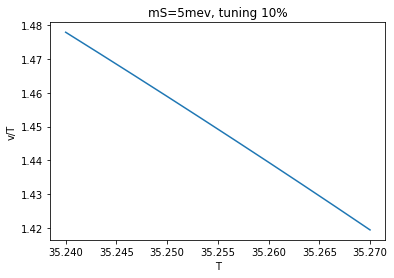

In [23]:
plt.plot(phaselist[0], phaselist[1])
plt.ylabel('v/T')
plt.xlabel('T')
plt.title('mS=5mev, tuning 10%')

Text(0.5, 1.0, 'mS=5mev, tuning 10%, v/T at T vs that at Tn1d')

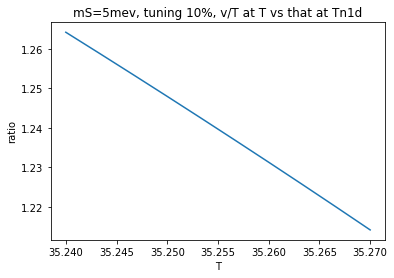

In [32]:
plt.plot(ratiolist[0], ratiolist[1])
plt.ylabel('ratio')
plt.xlabel('T')
plt.title('mS=5mev, tuning 10%, v/T at T vs that at Tn1d')